# Analysis of IPython git repository

In [1]:
import git
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import networkx as nx
import random
from itertools import islice
import  matplotlib.dates as mdate
import re as re

In [2]:
%config IPCompleter.greedy = True
%matplotlib inline
style.use("ggplot")

Use gitpython to access and query the git repository downloaded in directory

In [3]:
gitdirectory = "../bigbang/archives/sample-git-repos/ipython/"
repo = git.Repo(gitdirectory)

In [4]:
for i in islice(repo.iter_commits(),10):
    print(i,repo.commit(i).author)

3e49b3cd7f4e32bedf5a5666ea1a967f7791a2bd Min RK
5b9cee89e038fd28cadeb5065fc5d4aad699cbd7 Frazer McLean
f0fa6349991967212c4ad30a07200c7ea2201919 Min RK
a08029261ca835a534dbfa9e76239d3a6c6d006d Jason Grout
068f9d2552e2b31a4e0d83310a10659c9a066c19 Matthias Bussonnier
89da3f523d2be13032a486717d99eb4478740775 Thomas Kluyver
6ea81c9640afa25712c6dd2f2a39337000cf2fc4 Andrew Murray
3dcf94a47dcd54529b7e4d5cca8dbd8fac4ed7e2 Min RK
8137f8f0dfd0183450b535b362c4d537f2e4aa9a Min RK
1603d69e333dae0fd770869d8575709bea846b26 Min RK


In [28]:
def clean(string):
    return string.replace(" <>","").replace("é","e").strip()

def index_name_mail(tuples, verbose=True):
    
    #il faudrait potentiellement avoir trois niveaux : la forme initiale, la forme nettoyée et le cluster
    
    G = nx.Graph()
    for i in tuples:
        mail,name,div = i
        
        if mail == "None" and "fperez" in name:
            mail = "fernando.perez@berkeley.edu"
        if mail == "None" and "vainio" in name:
            mail = "vivainio@gmail.com"
        if mail in ["None",""]:
            mail = str(random.randint(0,10000000))
        if name in ["None",""]:
            name = str(random.randint(0,10000000))
        
        if not mail in G.node:
            G.add_node(mail, status = "mail")
        if not name in G.node:
            G.add_node(name, status = "name")
        G.add_edge(mail,name)

    dict_clusters = {}
    dict_individual = {}
    dict_mails = {}
    dict_names = {}
    
    l = sorted(nx.connected_components(G), key = len, reverse=True)
    
    for i in range(0,len(l)):
        if len(l[i])>10 and verbose:
            print("\nCareful, a component contain more than {data} 10 entities. Maybe there is an homonym".format(data=l[i]))
        for j in l[i]:
            dict_clusters[j] = i
        a = sorted([u for u in l[i] if not "@" in u and not " at " in u], key = len, reverse=True)
        if len(a)==0:
            dict_individual[i] = l[i][0]
        else:
            dict_individual[i] = a[0]
            
    for i in [i for i in G.node if G.node[i]["status"]=='mail']:
        name = dict_individual[dict_clusters[i]]
        dict_mails[i] = name.title()+" [id:"+str(dict_clusters[i])+"]"

    for i in [i for i in G.node if G.node[i]["status"]=='name']:
        name = dict_individual[dict_clusters[i]]
        dict_names[i] = name.title()+" [id:"+str(dict_clusters[i])+"]"
        
    return dict_clusters,dict_individual, dict_mails, dict_names, G

In [6]:
repo.commit("6ea81c9640afa25712c6dd2f2a39337000cf2fc4").author.email,\
repo.commit("6ea81c9640afa25712c6dd2f2a39337000cf2fc4").author.name

('radarhere@gmail.com', 'Andrew Murray')

In [29]:
lcommits = [datetime.datetime.fromtimestamp(repo.commit(i).authored_date) for i in repo.iter_commits()]
idcommits= [(clean(str(repo.commit(i).author.email)),clean(str(repo.commit(i).author.name)),len(repo.commit(i).parents)) for i in repo.iter_commits()] 

In [31]:
[i for i in idcommits if "vainio" in i[0]]

[('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 2),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 2),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 2),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@gmail.com', 'Ville M. Vainio', 1),
 ('vivainio@g

In [32]:
dict_clusters,dict_individual, dict_mails, dict_names, G = index_name_mail(idcommits,False)
def attribute(key):
    """
    match unique authors
    """
    try:
        return dict_mails[key[0]]
    except:
        #return key[0]+"|"+key[1]
        try:
            return dict_names[key[1]]
        except:
            return key[0]+"|"+key[1]

In [33]:
acommits = list(map(lambda x: attribute(x), idcommits))
tcommits = list(map(lambda x: "C" if x[2]==1 else "PR", idcommits))

In [34]:
commits = pd.DataFrame({"Total":np.ones(len(lcommits)),"author":acommits,"type":tcommits},index=lcommits)

In [35]:
commits_authors = pd.pivot_table(commits.reset_index(), index="index",columns=["type","author"]).fillna(0)
commits_authors = commits_authors["Total"].resample("Q",how="sum")
commits_authors

type                     C                                                  \
author     5141376 [id:36] 5506341 [id:49] 8155027 [id:2] 8358890 [id:259]   
index                                                                        
2005-09-30               0               2              0                0   
2005-12-31               0               0              0                0   
2006-03-31               0               0              0                0   
2006-06-30               0               0              0                0   
2006-09-30               0               0              0                0   
2006-12-31               0               0             12                0   
2007-03-31               0               0              0                0   
2007-06-30               0               0              0                0   
2007-09-30               0               0              0                0   
2007-12-31               2               0              0                0   
2008-03-31               0               0              0                0   
2008-06-30               0               0              0                0   
2008-09-30               0               0              0                0   
2008-12-31               0               0              0                0   
2009-03-31               0               0              0                0   
2009-06-30               0               0              0                0   
2009-09-30               0               0              0                0   
2009-12-31               0               0              0                0   
2010-03-31               0               0              0                0   
2010-06-30               0               0              0                1   
2010-09-30               0               0              0                0   
2010-12-31               0               0              0                0   
2011-03-31               0               0              0                0   
2011-06-30               0               0              0                0   
2011-09-30               0               0              0                0   
2011-12-31               0               0              0                0   
2012-03-31               0               0              0                0   
2012-06-30               0               0              0                0   
2012-09-30               0               0              0                0   
2012-12-31               0               0              0                0   
2013-03-31               0               0              0                0   
2013-06-30               0               0              0                0   
2013-09-30               0               0              0                0   
2013-12-31               0               0              0                0   
2014-03-31               0               0              0                0   
2014-06-30               0               0              0                0   
2014-09-30               0               0              0                0   
2014-12-31               0               0              0                0   
2015-03-31               0               0              0                0   
2015-06-30               0               0              0                0   
2015-09-30               0               0              0                0   

type                                                                   \
author     9302863 [id:4] Aaron Culich [id:459] Aaron Meurer [id:184]   
index                                                                   
2005-09-30              0                     0                     0   
2005-12-31              0                     0                     0   
2006-03-31              0                     0                     0   
2006-06-30              0                     0                     0   
2006-09-30              0                     0         

In [31]:
{i:commits_authors["C"][i].sum() for i in commits_authors["C"].keys()}

{'1454476 [id:75]': 2.0,
 '1717838 [id:62]': 2.0,
 '4440876 [id:6]': 10.0,
 '4940169 [id:4]': 12.0,
 '7881901 [id:437]': 1.0,
 '9456570 [id:36]': 2.0,
 'Aaron Culich [id:216]': 1.0,
 'Aaron Meurer [id:139]': 15.0,
 'Abe Guerra [id:207]': 1.0,
 'Abhinav Upadhyay [id:343]': 6.0,
 'Adal Chiriliuc [id:131]': 1.0,
 'Adam Davis [id:272]': 1.0,
 'Adam Hodgen [id:445]': 1.0,
 'Adam Riggall [id:146]': 2.0,
 'Administrator [id:161]': 8.0,
 'Adrian Price-Whelan [id:196]': 1.0,
 'Aenugu Sai Kiran Reddy [id:103]': 1.0,
 'Ahmet Bakan [id:366]': 3.0,
 'Ajholyoake [id:421]': 1.0,
 'Alberto Valverde [id:117]': 1.0,
 'Alcides [id:423]': 2.0,
 'Alex Kramer [id:441]': 2.0,
 'Alex Rudy [id:420]': 2.0,
 'Alexander Belopolsky [id:235]': 3.0,
 'Allen Riddell [id:359]': 1.0,
 'Amin Bandali [id:110]': 2.0,
 'Anatoly Techtonik [id:460]': 1.0,
 'Anders Hovmöller [id:144]': 1.0,
 'Andre Matos [id:203]': 1.0,
 'Andrea Bedini [id:328]': 2.0,
 'Andreas Amann [id:250]': 1.0,
 'Andrew Dawes [id:214]': 10.0,
 'Andrew Gi

Daily commits

In [36]:
def add_df_author(author,df):
    """
    pivot table for a spectific author
    """
    r = re.search("(.*) \[id:(.*)\]",author)
    print(r.group(1))
    df[r.group(1)] = df["author"].map(lambda x : 1 if "id:"+r.group(2) in x else 0)
    return df

In [37]:
l = commits["author"].value_counts()[0:20]
dict(l)
for i in sorted(dict(l),key=lambda x : l[x],reverse=True):
    commits = add_df_author(i,commits)

Min Ragan-Kelley
Thomas Kluyver
Jonathan Frederic
Matthias Bussonnier
Brian E. Granger
Fernando Perez
Ville M. Vainio
Paul Ivanov
Evan Patterson
Bradley M. Froehle
Jessica B. Hamrick
Jason Grout
Damián Avila
Takafumi Arakaki
Sylvain Corlay
Jã¶Rgen Stenarson
Gael Varoquaux
Walter.Doerwald
Kyle Kelley
Scott Sanderson


In [43]:
def plotPRC(key,table):
    df = pd.DataFrame()
    try:
        df["C"] = table["C"][key]
    except:
        df["C"] = pd.Series(np.zeros(len(table.index)))
    try:
        df["PR"] = table["PR"][key]
    except:
        df["PR"] = pd.Series(np.zeros(len(table.index)))
    df.plot(title=key)

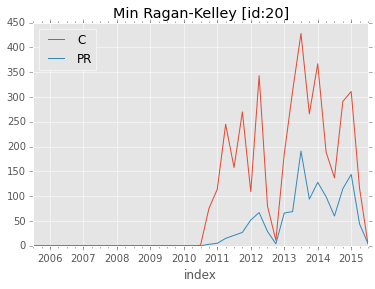

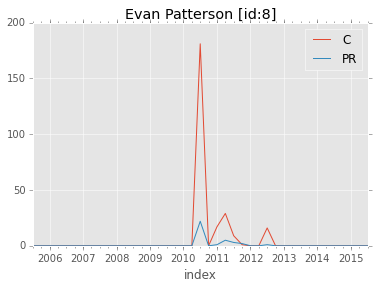

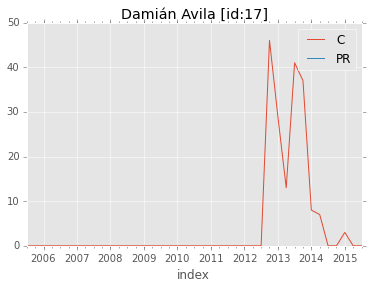

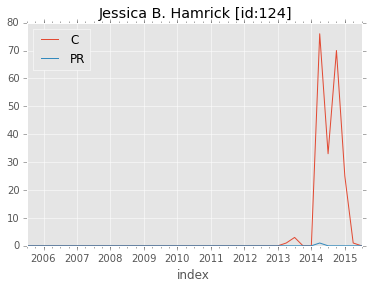

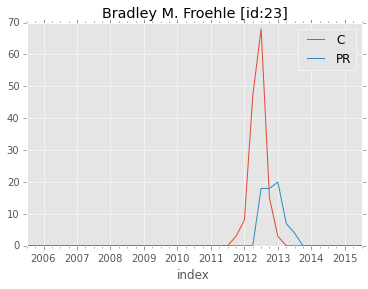

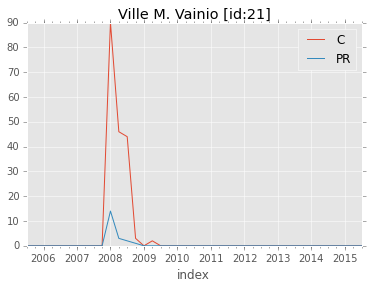

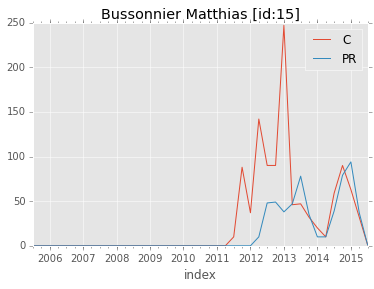

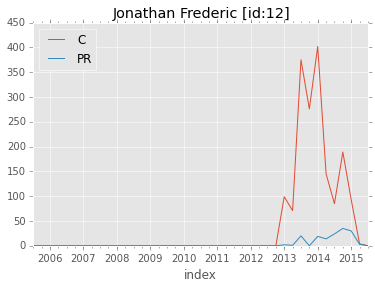

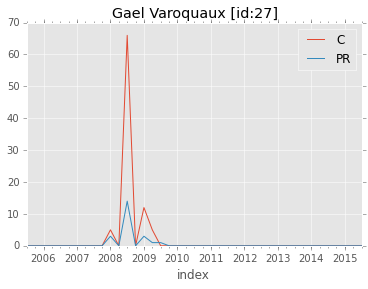

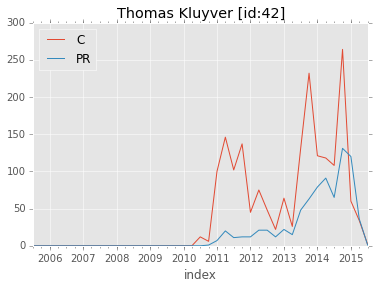

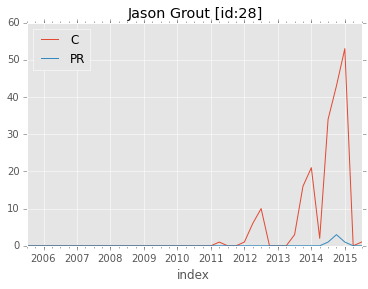

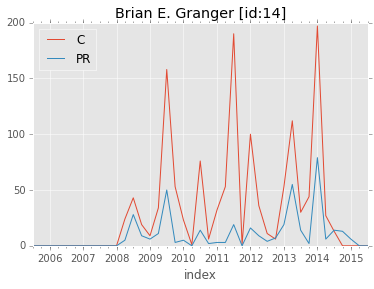

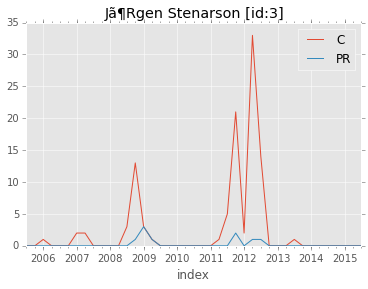

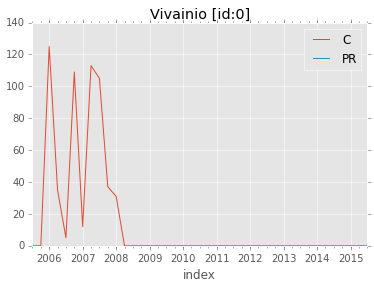

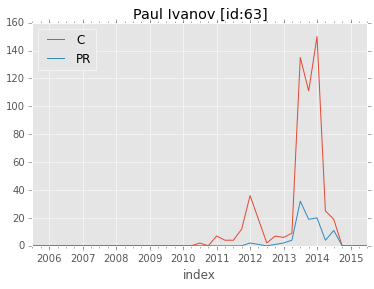

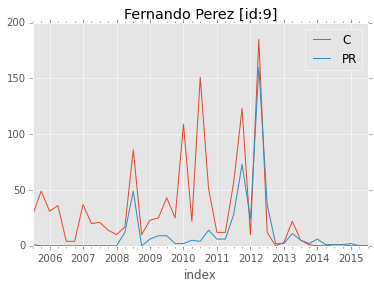

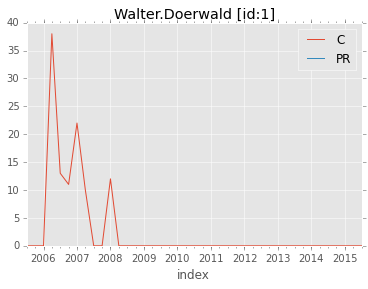

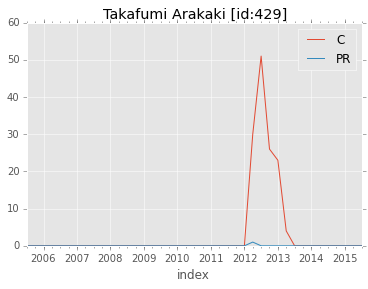

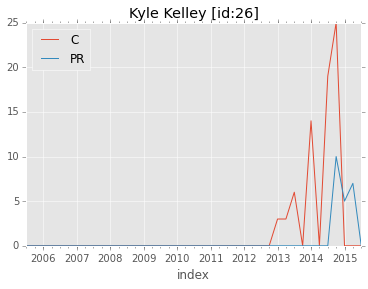

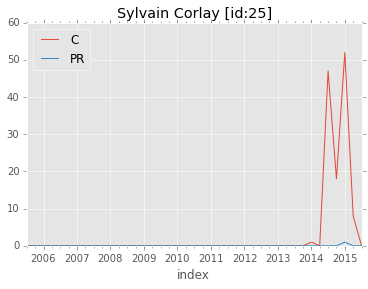

In [44]:
for i in [i for i in dict(l)]:
    plotPRC(i,commits_authors)

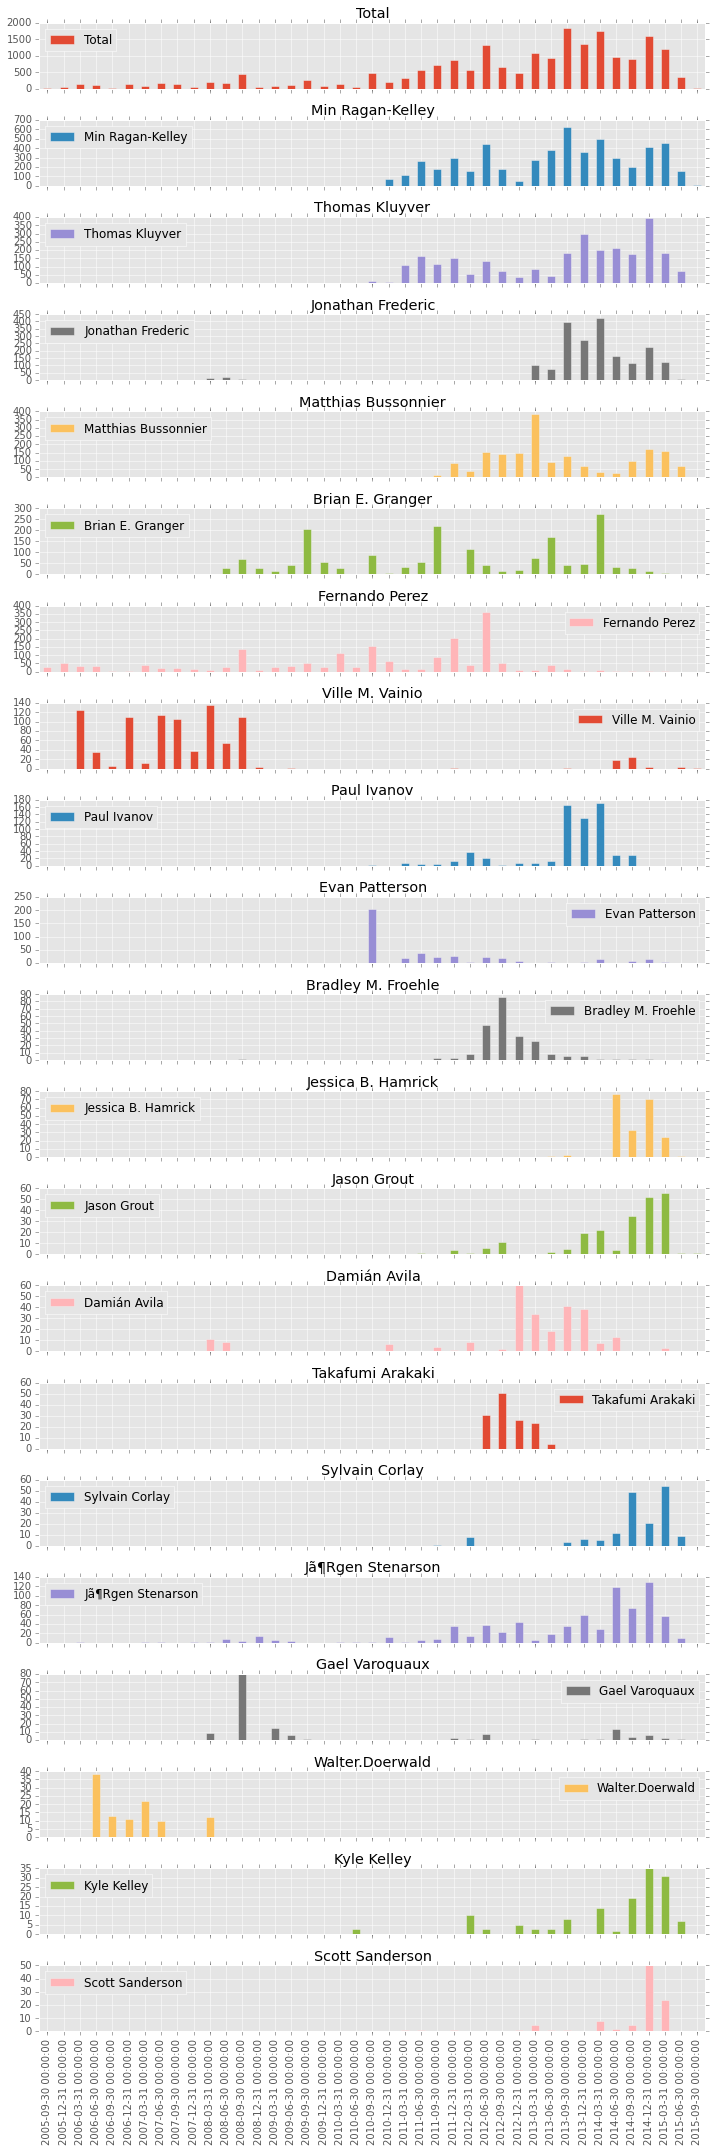

In [38]:
daily = commits.resample("Q",how="sum")
daily.plot(subplots= True,figsize=(10,30),kind="bar")
plt.tight_layout()
plt.savefig("git-top-commiters.png")

Commits by day of the week

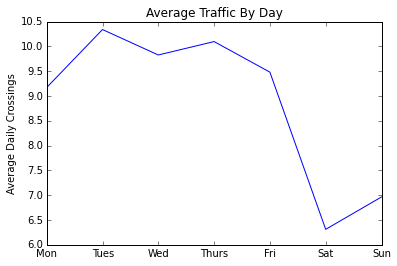

In [54]:
daily['dayofweek'] = daily['number'].index.dayofweek
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

grouped = daily.groupby('dayofweek')['number'].mean()
grouped.index = days
grouped.plot()

plt.title("Average Traffic By Day")
plt.ylabel("Average Daily Crossings");

In [40]:
for i in islice(repo.iter_commits(),100):
    print(repo.commit(i).parents,repo.commit(i).summary,datetime.datetime.fromtimestamp(repo.commit(i).authored_date))

(<git.Commit "f0fa6349991967212c4ad30a07200c7ea2201919">, <git.Commit "5b9cee89e038fd28cadeb5065fc5d4aad699cbd7">) Merge pull request #8651 from RazerM/master 2015-07-23 10:01:30
(<git.Commit "f0fa6349991967212c4ad30a07200c7ea2201919">,) Fix minor documentation typo 2015-07-23 03:06:06
(<git.Commit "068f9d2552e2b31a4e0d83310a10659c9a066c19">, <git.Commit "a08029261ca835a534dbfa9e76239d3a6c6d006d">) Merge pull request #8643 from jasongrout/trait-instances 2015-07-20 13:28:03
(<git.Commit "3dcf94a47dcd54529b7e4d5cca8dbd8fac4ed7e2">,) Use instances of traits instead of trait classes 2015-07-20 13:12:57
(<git.Commit "89da3f523d2be13032a486717d99eb4478740775">, <git.Commit "702159755d89990092d0ae303d88ef4f164c4b33">) Merge pull request #8601 from Carreau/no-install-ext 2015-07-15 11:34:46
(<git.Commit "3dcf94a47dcd54529b7e4d5cca8dbd8fac4ed7e2">, <git.Commit "6ea81c9640afa25712c6dd2f2a39337000cf2fc4">) Merge pull request #8632 from radarhere/patch-1 2015-07-14 09:18:42
(<git.Commit "3dcf94a4